In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='7'
import argparse
import glob
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets import DatasetTemplate
from pcdet.models import build_network, load_data_to_gpu
from pcdet.utils import common_utils

In [2]:
class DemoDataset(DatasetTemplate):
    def __init__(self, dataset_cfg, class_names, training=True, root_path=None, logger=None, ext='.bin'):
        """
        Args:
            root_path:
            dataset_cfg:
            class_names:
            training:
            logger:
        """
        super().__init__(
            dataset_cfg=dataset_cfg, class_names=class_names, training=training, root_path=root_path, logger=logger
        )
        self.root_path = root_path
        self.ext = ext
        data_file_list = glob.glob(str(root_path / f'*{self.ext}')) if self.root_path.is_dir() else [self.root_path]

        data_file_list.sort()
        self.sample_file_list = data_file_list

    def __len__(self):
        return len(self.sample_file_list)

    def __getitem__(self, index):
        if self.ext == '.bin':
            points = np.fromfile(self.sample_file_list[index], dtype=np.float32).reshape(-1, 4)
        elif self.ext == '.npy':
            points = np.load(self.sample_file_list[index])
        else:
            raise NotImplementedError

        input_dict = {
            'points': points,
            'frame_id': index,
        }

        data_dict = self.prepare_data(data_dict=input_dict)
        return data_dict

class Config():
    def __init__(self, cfg_file, data_path, ckpt, ext='.bin'):
        super().__init__()
        self.cfg_file = cfg_file
        self.data_path = data_path
        self.ckpt = ckpt
        self.ext = ext

def parse_config(cfg_file, data_path, ckpt, ext='.bin'):
    args = Config(cfg_file, data_path, ckpt, ext)
    cfg_from_yaml_file(args.cfg_file, cfg)
    return args, cfg

def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size = 0.1, xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    axes_limits = [
                   [-51.2, 51.2],
                   [-51.2, 51.2],
                   [-6, 6]
    ]
    axes_str = ['X','Y','Z']
    ax.grid = False

    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

def compute_3d_box(box):
    x = box[0]
    y = box[1]
    z = box[2]

    l = box[3]  # dx
    w = box[4]  # dy
    h = box[5]  # dz

    yaw = box[6]
    R = np.array([[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]])
    x_corners = [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2]
    y_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
    z_corners = [-h / 2, -h / 2, -h / 2, -h / 2, h / 2, h / 2, h / 2, h / 2]

    corners_3d = np.dot(R, np.array([x_corners,y_corners,z_corners]))
    corners_3d[0, :] = corners_3d[0, :] + x
    corners_3d[1, :] = corners_3d[1, :] + y
    corners_3d[2, :] = corners_3d[2, :] + z

    dir_x = l / 2.0 * np.cos(yaw)
    dir_y = l / 2.0 * np.sin(yaw)
    arrow_origin = np.array([x, y, z])[:, None]
    arrow_end = np.array([x + dir_x, y + dir_y, z])[:, None]
    corners_3d = np.concatenate([corners_3d, arrow_origin, arrow_end], -1)
    return corners_3d

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7], [8, 9]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=1)

In [3]:
# name_list = []
# box_list = []
# num = 4
# for num in range(2000, 2575):
#     index = str(num).zfill(6)
#     index = index+'.bin'
#     name_list.append(index)
#     num += 4
# for i in range(len(name_list)):
#     box_list.append(os.path.join('/home/data/dataset/zhisuo_lidar_data/tmp', name_list[i][:-3]+'txt'))
#     name_list[i] = os.path.join('/home/data/dataset/zhisuo_lidar_data/data/lidar', name_list[i])
    

# for i in range(len(name_list)):
#     cfg_file =  '/home/hning/lidar/my_openpcdet/tools/cfgs/zhisuo_models/centerpoint.yaml'
#     ckpt =  '/home/hning/lidar/my_openpcdet/output/zhisuo_models/centerpoint/default/ckpt/checkpoint_epoch_120.pth'
#     data_path = name_list[i]
#     ext = '.bin'

#     args, cfg = parse_config(cfg_file, data_path, ckpt, ext)
#     logger = common_utils.create_logger()
#     logger.info('-----------------Quick Demo of OpenPCDet-------------------------')
#     demo_dataset = DemoDataset(
#         dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
#         root_path=Path(args.data_path), ext=args.ext, logger=logger
#     )
#     logger.info(f'Total number of samples: \t{len(demo_dataset)}')

#     model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
#     model.load_params_from_file(filename=args.ckpt, logger=logger, to_cpu=True)
#     model.cuda()
#     model.eval()
#     with torch.no_grad():
#         for idx, data_dict in enumerate(demo_dataset):
#             logger.info(f'Visualized sample index: \t{idx + 1}')
            
#             data_dict = demo_dataset.collate_batch([data_dict])
#             load_data_to_gpu(data_dict)
#             pred_dicts, _ = model.forward(data_dict)
#             points=data_dict['points'][:, 1:]
#             ref_boxes=pred_dicts[0]['pred_boxes'].cpu().numpy()
#             ref_scores=pred_dicts[0]['pred_scores'].cpu().numpy()
#             ref_labels=pred_dicts[0]['pred_labels'].cpu().numpy()
#             def convert_labels(labels):
#                 labels = labels
#                 new_labels = []
#                 labels_dict = {0:'vehicle', 1:'pedestrian', 2:'bicycle', 3:'large_vehicle', 4:'small_lowvel_vehicle', 5:'huge_vehicle', \
#                             6:'cone'}
#                 for i in range(len(labels)):
#                     new_labels.append(labels_dict[labels[i]-1])
#                 return new_labels
#             ref_labels = convert_labels(ref_labels)
#             with open(box_list[i], "w") as f_write:
#                 for i in range(len(ref_labels)):
#                     _label = ref_labels[i]
#                     _box = ref_boxes[i]
#                     _score = ref_scores[i]
#                     f_write.write(_label+' '+str(_box[0])+' '+str(_box[1])+' '+str(_box[2])+' '+str(_box[3])+' '\
#                                     +str(_box[4])+' '+str(_box[5])+' '+str(_box[6])+' '+str(_score)+'\n')
#             print(ref_labels)
#     logger.info('Demo done.')

In [4]:
cfg_file =  '/home/hning/lidar/my_openpcdet/tools/cfgs/zhisuo_models/centerpoint.yaml'
ckpt =  '/home/hning/lidar/my_openpcdet/output/zhisuo_models/centerpoint/default/ckpt/checkpoint_epoch_120.pth'
data_path = '/home/data/dataset/zhisuo_lidar_data/raw_data/mems/bin/2022-07-22-15-46-53-0596.bin'
ext = '.bin'

args, cfg = parse_config(cfg_file, data_path, ckpt, ext)
logger = common_utils.create_logger()
logger.info('-----------------Quick Demo of OpenPCDet-------------------------')
demo_dataset = DemoDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path(args.data_path), ext=args.ext, logger=logger
)
logger.info(f'Total number of samples: \t{len(demo_dataset)}')

model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
model.load_params_from_file(filename=args.ckpt, logger=logger, to_cpu=True)
model.cuda()
model.eval()
with torch.no_grad():
    for idx, data_dict in enumerate(demo_dataset):
        logger.info(f'Visualized sample index: \t{idx + 1}')
        
        data_dict = demo_dataset.collate_batch([data_dict])
        load_data_to_gpu(data_dict)
        pred_dicts, _ = model.forward(data_dict)
        points=data_dict['points'][:, 1:]
        ref_boxes=pred_dicts[0]['pred_boxes'].cpu().numpy()
        ref_scores=pred_dicts[0]['pred_scores'].cpu().numpy()
        ref_labels=pred_dicts[0]['pred_labels'].cpu().numpy()
        print(ref_boxes, ref_scores)
        def convert_labels(labels):
            labels = labels
            new_labels = []
            labels_dict = {0:'vehicle', 1:'pedestrian', 2:'bicycle', 3:'large_vehicle', 4:'small_lowvel_vehicle', 5:'huge_vehicle', \
                           6:'cone'}
            for i in range(len(labels)):
                new_labels.append(labels_dict[labels[i]-1])
            return new_labels
        ref_labels = convert_labels(ref_labels)
        print(ref_labels)
logger.info('Demo done.')

2022-08-17 08:48:45,173   INFO  -----------------Quick Demo of OpenPCDet-------------------------
2022-08-17 08:48:45,175   INFO  Total number of samples: 	1
2022-08-17 08:48:49,640   INFO  ==> Loading parameters from checkpoint /home/hning/lidar/my_openpcdet/output/zhisuo_models/centerpoint/default/ckpt/checkpoint_epoch_120.pth to CPU
2022-08-17 08:48:49,721   INFO  ==> Checkpoint trained from version: pcdet+0.5.2+e621710+py8a80890
2022-08-17 08:48:49,845   INFO  ==> Done (loaded 179/179)
2022-08-17 08:48:49,895   INFO  Visualized sample index: 	1
2022-08-17 08:48:49,983   INFO  Demo done.


[[11.649961   -3.447918   -0.18494418  4.4655743   1.9843667   1.4851118
   2.2698805 ]
 [11.657069   -3.360052   -0.18437946  4.4031596   1.9566418   1.4626005
   2.314516  ]
 [11.560969   -3.4561634  -0.18320072  4.402956    1.9583526   1.4633833
   2.212678  ]
 [11.747849   -3.3503895  -0.19007656  4.449802    1.9836258   1.4892646
   2.3743765 ]
 [11.844046   -3.2534504  -0.18633142  4.4671288   1.9967563   1.4919444
   2.4921284 ]
 [11.7569065  -3.2617817  -0.18899274  4.402929    1.9640852   1.4695643
   2.4365335 ]
 [11.739541   -3.4398136  -0.18992013  4.4951687   2.0086002   1.5133449
   2.3337374 ]
 [11.552516   -3.5405235  -0.19398719  4.4574876   1.9811612   1.4877167
   2.1968634 ]
 [11.836223   -3.340784   -0.18372798  4.5153246   2.0153248   1.5140036
   2.4389617 ]
 [11.644352   -3.5327778  -0.19075692  4.520065    2.0086954   1.5128984
   2.2478347 ]
 [11.46386    -3.4636707  -0.18584138  4.3609505   1.9327104   1.4457059
   2.1620839 ]
 [11.460309   -3.5483208  -0.195

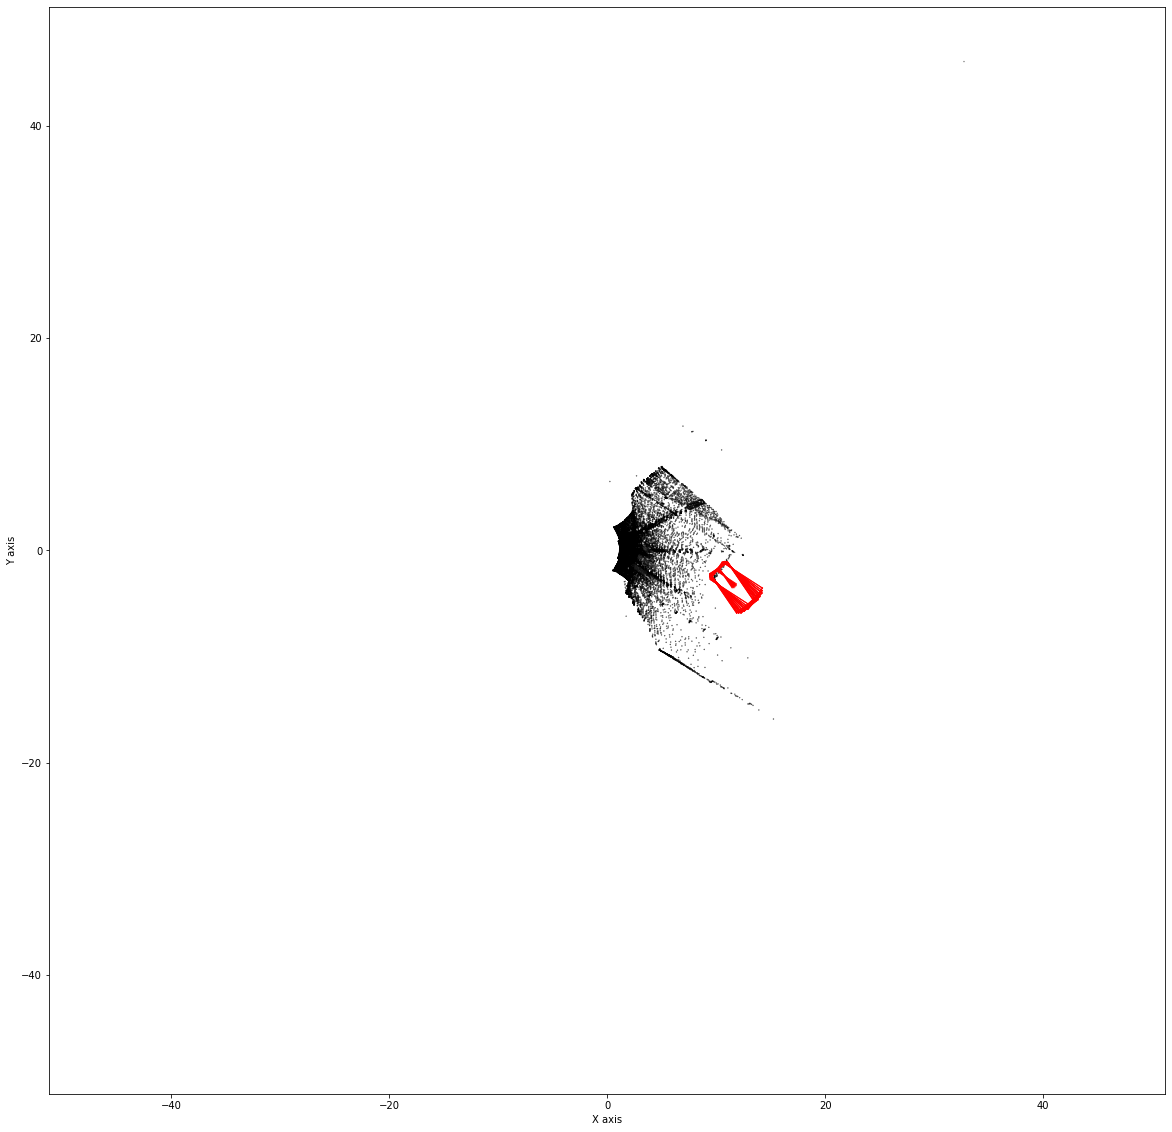

In [5]:
color_map = {'vehicle': 'red', 'pedestrian': 'blue', 'bicycle': 'green', \
             'large_vehicle': 'gold', 'small_lowvel_vehicle': 'purple', 'huge_vehicle': 'pink', \
             'cone': 'brown', 'small_animal': 'black', 'big_animal': 'midnightblue', 'small_handcart': 'lightslategrey'}
points = np.fromfile(data_path, dtype=np.float32).reshape(-1,4)
fig, ax = plt.subplots(figsize=(20, 20))
draw_point_cloud(ax, points[::2], axes=[0, 1]) #每2个点画一个
for i in range(ref_boxes.shape[0]):
    cornel_3d = compute_3d_box(ref_boxes[i, :])
    draw_box(ax, (cornel_3d), axes=[0,1], color=color_map[ref_labels[i]]) 

In [ ]:
data_path = '/home/data/dataset/zhisuo_lidar_data/data/lidar/005592.bin'
points = np.fromfile(data_path, dtype=np.float32).reshape(-1,4)
# print(ref_boxes[0, :])
cornel_3d = compute_3d_box(ref_boxes[0, :])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(40,150)
draw_point_cloud(ax, points[::2], [0,1,2]) #每2个点画一个
draw_box(ax, (cornel_3d))